* Course: DSC630
* Title: Assignment 8.2
* Author Nels Findley
* 11/02/2025
* Description: Time Series Modeling

In [6]:
# Setup libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [9]:
# load dataset and view it
df = pd.read_csv('us_retail_sales.csv')

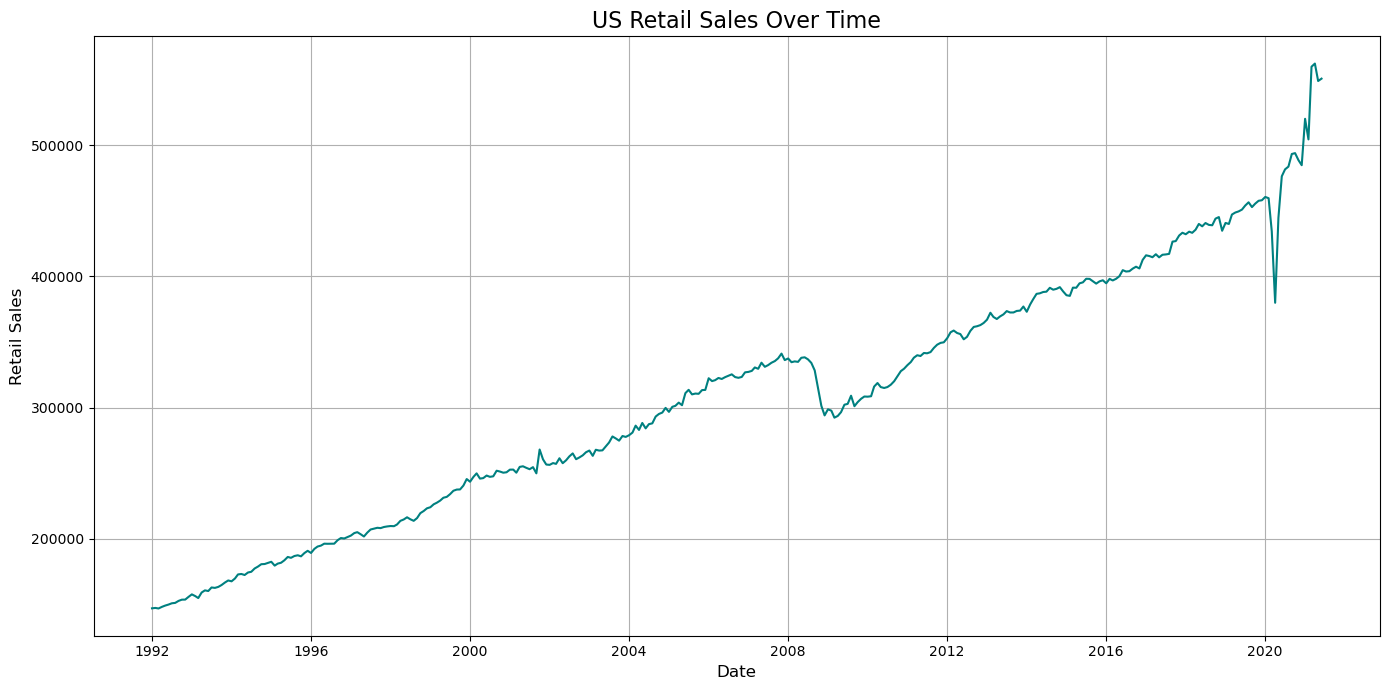

In [16]:
# Convert date format
df_long = df.melt(id_vars='YEAR', var_name='Month', value_name='Sales')
month_order = {'JAN': 1, 'FEB': 2, 'MAR': 3, 'APR': 4, 'MAY': 5, 'JUN': 6,
               'JUL': 7, 'AUG': 8, 'SEP': 9, 'OCT': 10, 'NOV': 11, 'DEC': 12}
df_long['Month_Num'] = df_long['Month'].map(month_order)

# Create Date column and drop old date fields
df_long['Date'] = pd.to_datetime(df_long['YEAR'].astype(str) + '-' + df_long['Month_Num'].astype(str) + '-01')
df_long = df_long.drop(columns=['Month', 'Month_Num', 'YEAR'])
df_long = df_long.sort_values(by='Date').reset_index(drop=True)

# Remove Null values
df_long.dropna(subset=['Sales'], inplace=True)

# Convert Sales to integer for plotting
df_long['Sales'] = df_long['Sales'].astype(int)

# Generate Time series graph
plt.figure(figsize=(14, 7))
plt.plot(df_long['Date'], df_long['Sales'], label='US Retail Sales', color='teal')
plt.title('US Retail Sales Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Retail Sales', fontsize=12)
plt.grid(True)
plt.tight_layout()

The Time series cleary shows an upgward trend in retial sales over the entire period. The retail sales only decreases during economic crisis such as 2008 financial crisis and 2020 covid-19 pandemic. Only during these two times period did sales decrease from previous years. 

In [17]:
# Split this data into a training and test set. Use the last year of data (July 2020 – June 2021) of data as your test set and the rest as your training set.
# Use the training set to build a predictive model for the monthly retail sales.
# Use the model to predict the monthly retail sales on the last year of data.
# Report the RMSE of the model predictions on the test set.


# Split the data set
split_point = len(df_long) - 12  # - 12 for last 12 months
train_df = df_long.iloc[:split_point].copy()
test_df = df_long.iloc[split_point:].copy()

# Create Time feature
train_df['Time'] = np.arange(len(train_df)) + 1 # Training set start at 1 and ends at 342
test_df['Time'] = np.arange(len(train_df), len(df_long)) + 1 # Test set to start at 343 and end at 354

# Create Month feature
train_df['Month'] = train_df['Date'].dt.month
test_df['Month'] = test_df['Date'].dt.month

# Convert Month to categorical/dummy variables
X_train = pd.get_dummies(train_df[['Time', 'Month']], columns=['Month'], drop_first=True)
X_test = pd.get_dummies(test_df[['Time', 'Month']], columns=['Month'], drop_first=True)
y_train = train_df['Sales']
y_test = test_df['Sales']

# Ensure both train and test have the same columns
missing_cols = set(X_train.columns) - set(X_test.columns)
for c in missing_cols:
    X_test[c] = 0
X_test = X_test[X_train.columns] # Reorder columns to match training set


#  Train the Model with Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on Test Set 
predictions = model.predict(X_test)

# Find RMSE 
rmse = np.sqrt(mean_squared_error(y_test, predictions))

# Display the results
results_df = test_df[['Date', 'Sales']].copy()
results_df['Predicted_Sales'] = predictions.astype(int)
results_df['Residual'] = results_df['Sales'] - results_df['Predicted_Sales']

print("\nRoot Mean Square Error (RMSE) on the Test Set:")
print(f"{rmse:,.2f}")
print("\nModel Prediction Results (Test Set):")
print(results_df)


Root Mean Square Error (RMSE) on the Test Set:
66,597.65

Model Prediction Results (Test Set):
          Date   Sales  Predicted_Sales  Residual
342 2020-07-01  481627           449954     31673
343 2020-08-01  483716           450994     32722
344 2020-09-01  493327           451299     42028
345 2020-10-01  493991           452552     41439
346 2020-11-01  488652           453244     35408
347 2020-12-01  484782           453698     31084
348 2021-01-01  520162           454525     65637
349 2021-02-01  504458           455477     48981
350 2021-03-01  559871           455979    103892
351 2021-04-01  562269           455054    107215
352 2021-05-01  548987           458084     90903
353 2021-06-01  550782           460300     90482


The high RMSE of 66,567.65 shows the failure of the model to capture the volatile surge in sales with the COVID-19 Pandemic and the subsequent recovery. 